In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [4]:
data = pd.read_csv("fake_news_data.csv")

In [5]:
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_colour = "#00bfbf"

In [6]:
stopwords_list=stopwords.words("english")

In [7]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [8]:
nlp=spacy.load("en_core_web_sm")

In [9]:
fact_news=data[data['fake_or_factual']=="Factual News"]
fake_news=data[data['fake_or_factual']=="Fake News"]


In [10]:
fake_spacydoc=list(nlp.pipe(fake_news["text"]))
fact_spacydoc=list(nlp.pipe(fact_news["text"]))

In [11]:
def extracttokens(doc):
    return [(i.text, i.ent_type_ ,i.pos )for i in doc]

In [12]:
faketagdf=[]
columns=["token","ner_tag","pos_tag"]
for i,doc in enumerate(fake_spacydoc):
    tags =[[token.text, token.ent_type, token.pos_] for token in doc]
    tags=pd.DataFrame(tags)
    tags.columns=columns
    faketagdf.append(tags)
faketagdf=pd.concat(faketagdf)

facttagdf=[]
columns=["token","ner_tag","pos_tag"]
for i,doc in enumerate(fact_spacydoc):
    tags =[[token.text, token.ent_type, token.pos_] for token in doc]
    tags=pd.DataFrame(tags)
    tags.columns=columns
    facttagdf.append(tags)
facttagdf=pd.concat(facttagdf)


In [13]:
faketagdf.head()

,token,ner_tag,pos_tag
0,There,0,PRON
1,are,0,VERB
2,two,397,NUM
3,small,0,ADJ
4,problems,0,NOUN


In [14]:
pos_count_fake=faketagdf.groupby(["token","pos_tag"]).size().reset_index(name="counts").sort_values(by="counts",ascending=False)
pos_count_fact=facttagdf.groupby(["token","pos_tag"]).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

In [15]:
pos_count_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [16]:
pos_count_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [17]:
top_entities_fakenews=faketagdf[faketagdf["ner_tag"] !=""].groupby(["token","ner_tag"]).size().reset_index(name="counts").sort_values(by="counts",ascending=False)
top_entities_factnews=facttagdf[facttagdf["ner_tag"] !=""].groupby(["token","ner_tag"]).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

In [18]:
top_entities_fakenews.head(40)

,token,ner_tag,counts
38,",",0,1871
7511,the,0,1613
53,.,0,1532
7598,to,0,1139
5914,of,0,876
2973,and,0,860
2760,a,0,790
0,,0,782
5120,in,0,676
7509,that,0,562


In [19]:
import seaborn as sns

In [20]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

In [21]:
unique_ner_tags = top_entities_fakenews['ner_tag'].unique()
cmap = plt.cm.get_cmap('tab20')
ner_palette = {tag: cmap(i/len(unique_ner_tags)) for i, tag in enumerate(unique_ner_tags)}

C:\Users\Maryam Rauf\AppData\Local\Temp\ipykernel_14088\251405292.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

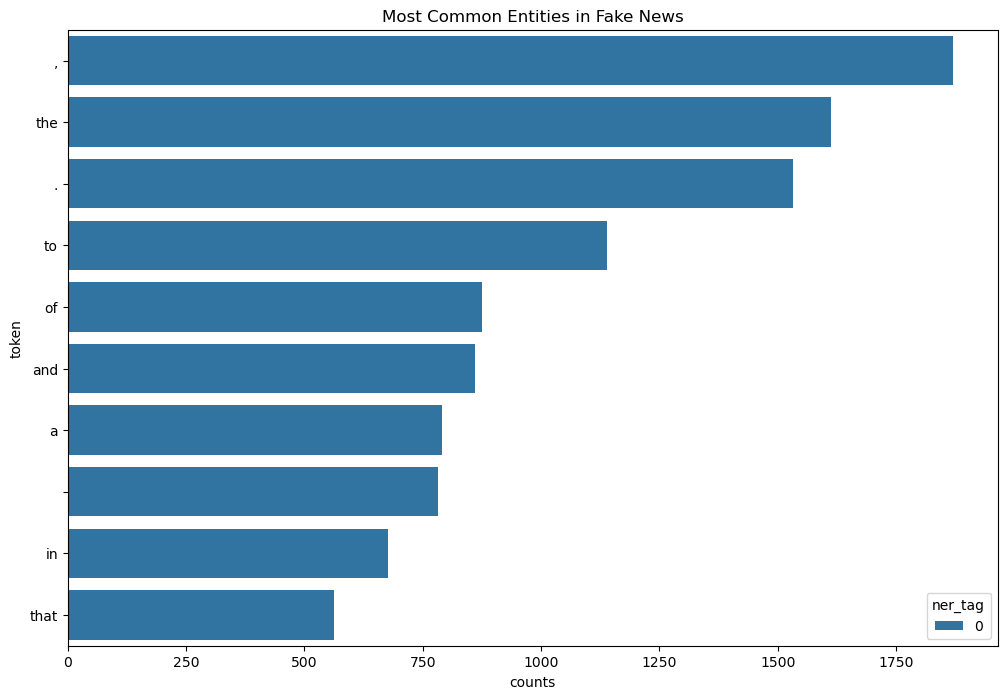

In [22]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data =top_entities_fakenews[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

In [23]:
data["text_clean"]=data.apply(lambda x:re.sub(r"^[^-]*-\s*","",x["text"]),axis=1)

In [24]:
data["text_clean"]=data["text_clean"].str.lower()

In [25]:
data["text_clean"]=data.apply(lambda x: re.sub(r"([^\w\s])","",x["text_clean"]),axis=1)

In [26]:
data["text_clean"]=data["text_clean"].apply(lambda x:" ".join([w for w in x.split() if w not in stopwords_list]))

In [27]:
data["text_clean"]=data.apply(lambda x: word_tokenize(x["text_clean"]),axis=1)

In [28]:
lm=WordNetLemmatizer()

In [29]:
data["text_clean"]=data["text_clean"].apply(lambda x:[lm.lemmatize(token) for token in x])

In [30]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [31]:
token_clean=sum(data["text_clean"],[])

In [32]:
unigrams=(pd.Series(nltk.ngrams(token_clean,1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7        (year,)    128
8  (republican,)    128
9        (also,)    124


C:\Users\Maryam Rauf\AppData\Local\Temp\ipykernel_14088\4019870307.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = "count",


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

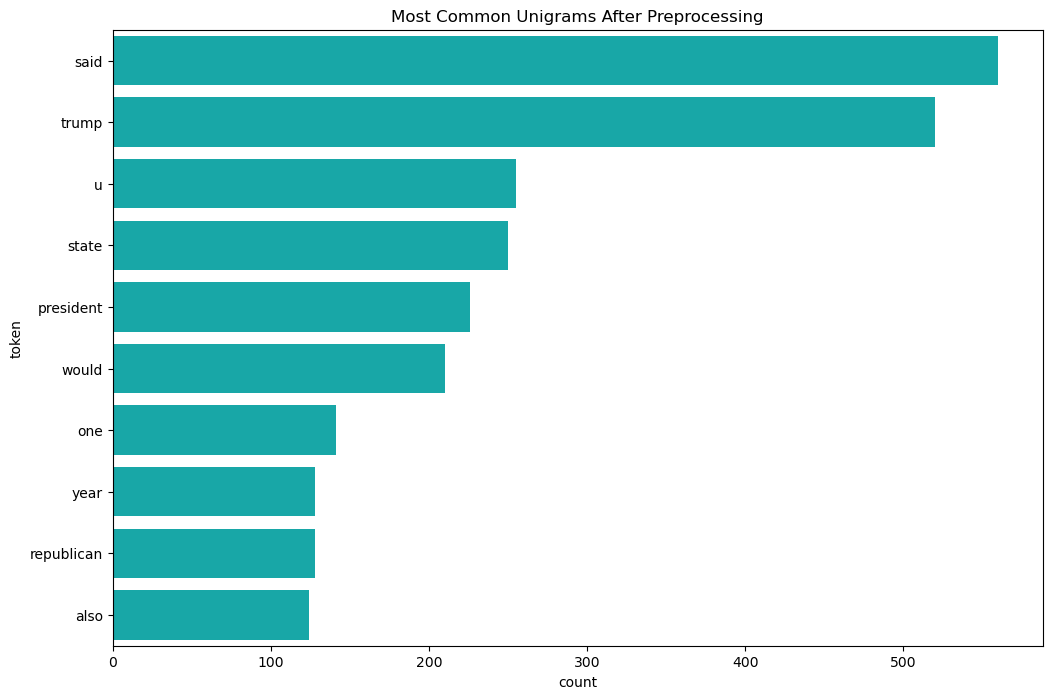

In [33]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0]) # extract the token from the tuple so we can plot it

sns.barplot(x = "count", 
            y = "token", 
            data=unigrams,
            orient = 'h',
            palette=[default_plot_colour],
            hue = "token", legend = False)\
.set(title='Most Common Unigrams After Preprocessing')

In [34]:
bigrams=(pd.Series(nltk.ngrams(token_clean,2)).value_counts()).reset_index()[:10]
print(bigrams)

                 index  count
0      (donald, trump)     92
1      (united, state)     80
2       (white, house)     72
3  (president, donald)     42
4   (hillary, clinton)     31
5          (new, york)     31
6         (image, via)     29
7     (supreme, court)     29
8     (official, said)     26
9        (food, stamp)     24


C:\Users\Maryam Rauf\AppData\Local\Temp\ipykernel_14088\927317914.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = "count",


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

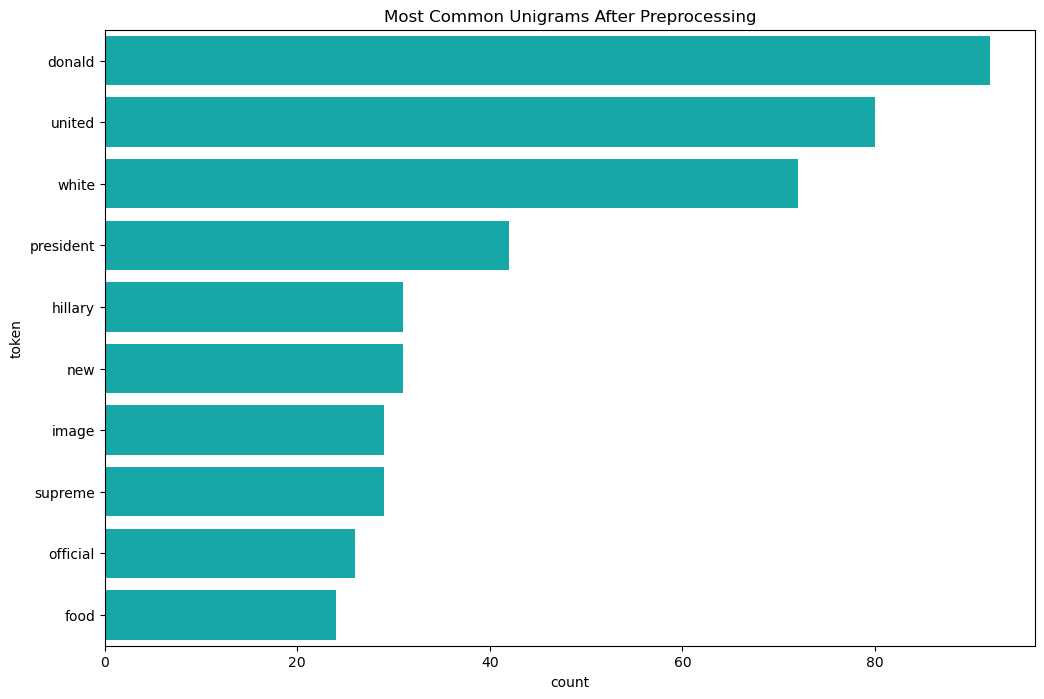

In [35]:
bigrams['token'] = bigrams['index'].apply(lambda x: x[0]) # extract the token from the tuple so we can plot it

sns.barplot(x = "count", 
            y = "token", 
            data=bigrams,
            orient = 'h',
            palette=[default_plot_colour],
            hue = "token", legend = False)\
.set(title='Most Common Unigrams After Preprocessing')

In [36]:
vs=SentimentIntensityAnalyzer()

In [37]:
data["sentiment_score"]=data["text"].apply(lambda x:vs.polarity_scores(x)['compound'])

In [38]:
data.head()

,title,text,date,fake_or_factual,text_clean,sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [39]:
bins=[-1,-0.1,0.1,1]
label=["negative","positive","neutral"]

In [40]:
data["sentiment_score_label"]=pd.cut(data["sentiment_score"],bins,labels=label)

In [41]:
data.head()

,title,text,date,fake_or_factual,text_clean,sentiment_score,sentiment_score_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,neutral
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,neutral


<Axes: xlabel='sentiment_score_label'>

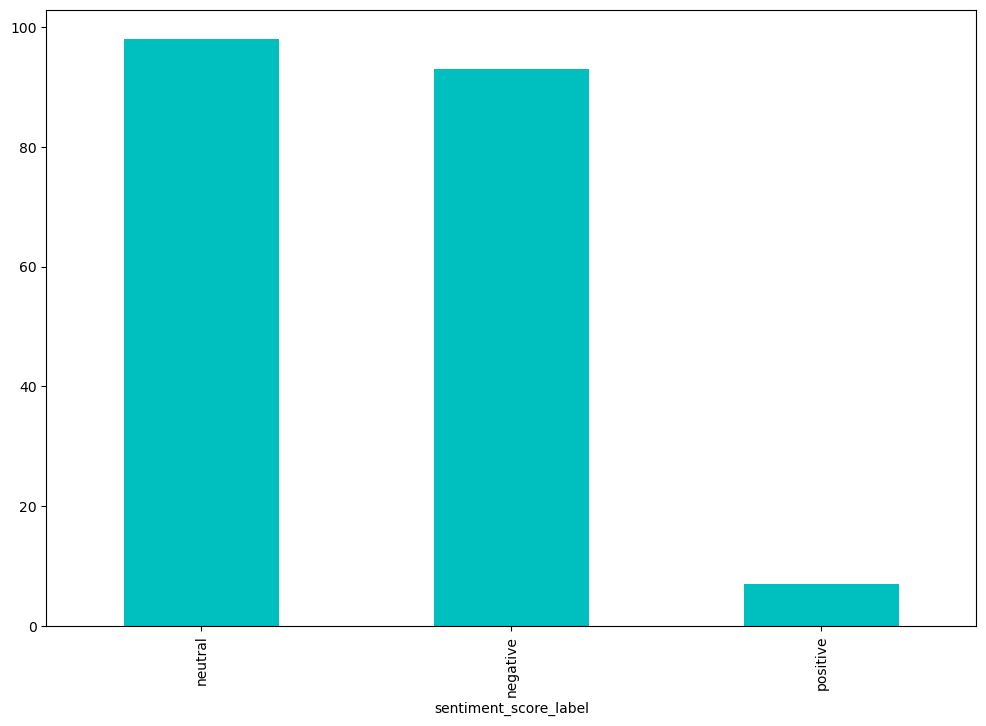

In [42]:
data["sentiment_score_label"].value_counts().plot.bar(color=default_plot_colour)

C:\Users\Maryam Rauf\AppData\Local\Temp\ipykernel_14088\1155874025.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'sentiment_by_news_type')]

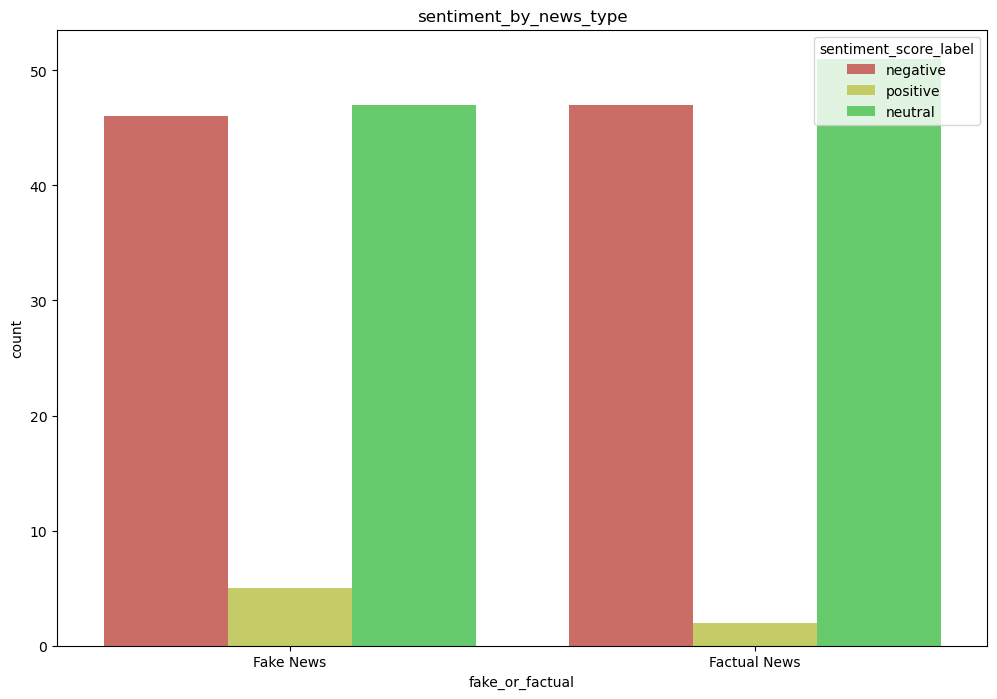

In [43]:
sns.countplot(
    x="fake_or_factual",
    hue="sentiment_score_label",
    palette=sns.color_palette("hls"),
    data=data).set(title="sentiment_by_news_type")

In [44]:
fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

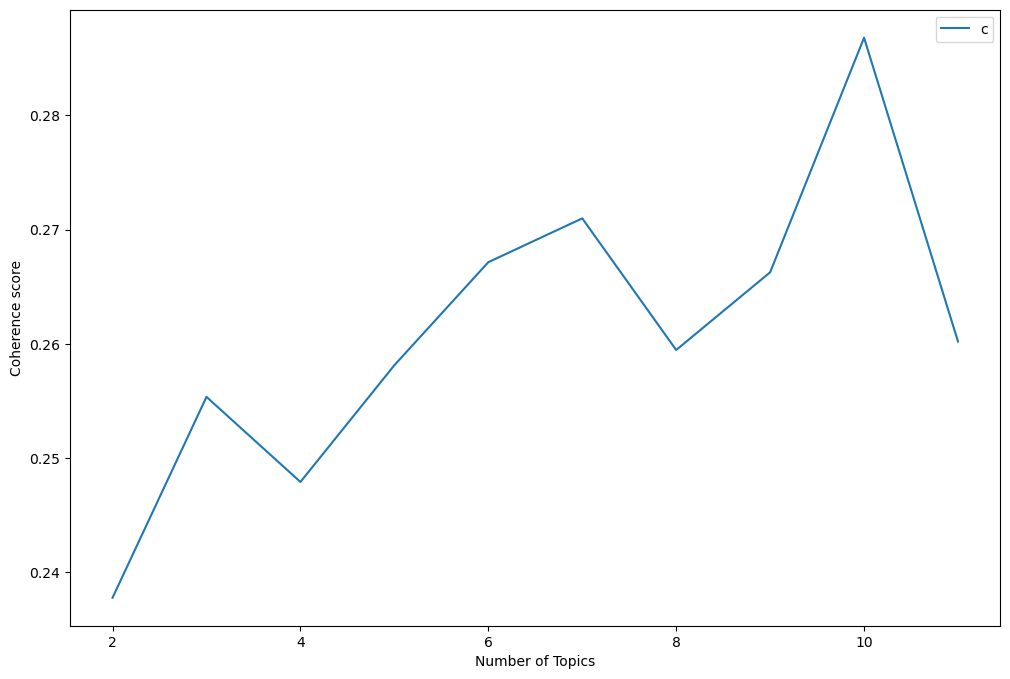

In [45]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
    
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [46]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [47]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

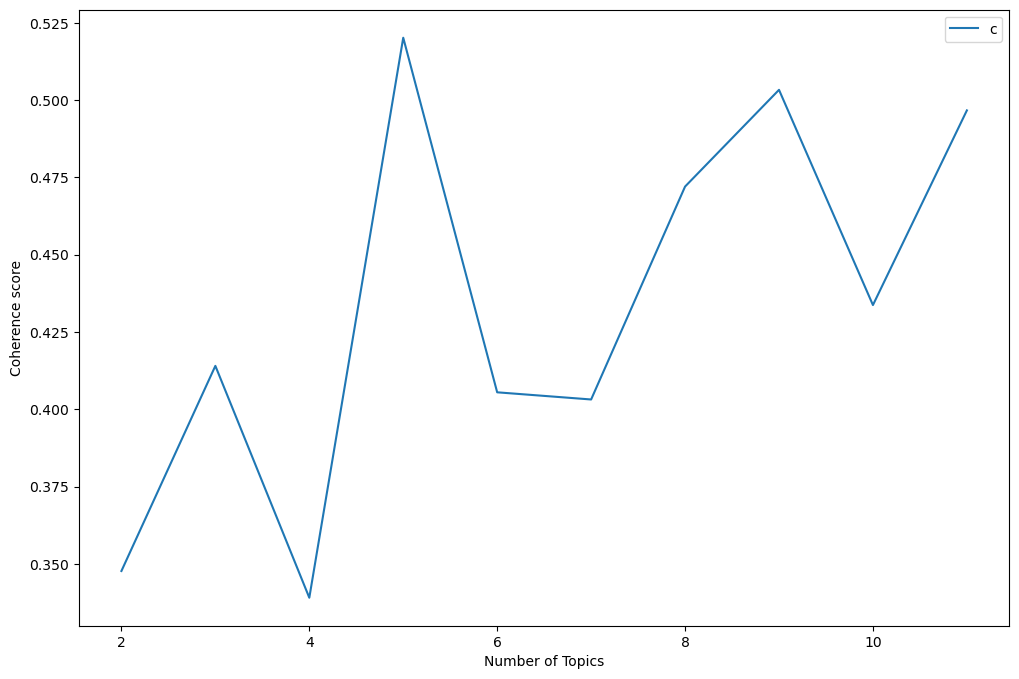

In [48]:
# create tfidf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [49]:
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=5)
lsa_fake.print_topics()

[(0,
  '-0.218*"trump" + -0.135*"clinton" + -0.094*"woman" + -0.087*"president" + -0.086*"republican" + -0.085*"obama" + -0.084*"party" + -0.083*"school" + -0.081*"said" + -0.079*"time"'),
 (1,
  '0.299*"boiler" + 0.253*"room" + 0.250*"acr" + 0.186*"jay" + 0.185*"animal" + 0.176*"episode" + 0.147*"analysis" + 0.122*"dyer" + 0.119*"mediamaniacs" + 0.119*"misguided"'),
 (2,
  '-0.219*"school" + 0.195*"clinton" + 0.163*"conference" + -0.151*"county" + -0.137*"student" + 0.120*"press" + 0.116*"trump" + 0.112*"hillary" + -0.101*"love" + 0.095*"email"'),
 (3,
  '0.375*"flynn" + 0.151*"russian" + 0.111*"email" + 0.109*"30" + 0.101*"department" + 0.100*"information" + 0.100*"nana" + 0.099*"official" + 0.098*"mccain" + -0.096*"trump"'),
 (4,
  '0.235*"trump" + 0.223*"flynn" + 0.166*"conference" + -0.165*"clinton" + -0.153*"dnc" + -0.151*"sander" + -0.127*"email" + 0.111*"press" + -0.109*"rich" + 0.084*"tax"')]

In [50]:
data.head()

,title,text,date,fake_or_factual,text_clean,sentiment_score,sentiment_score_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,neutral
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,neutral


In [51]:
X = [','.join(map(str, l)) for l in data['text_clean']]
Y = data['fake_or_factual']

In [52]:
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [53]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

In [62]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [63]:
y_pred_lr = lr.predict(X_test)

In [64]:
accuracy_score(y_pred_lr, y_test)

0.9

In [65]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.91      0.91      0.91        33
   Fake News       0.89      0.89      0.89        27

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



In [66]:
svm = SGDClassifier().fit(X_train, y_train)

In [67]:
y_pred_svm = svm.predict(X_test)

In [68]:
accuracy_score(y_pred_svm, y_test)

0.85

In [69]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.83      0.91      0.87        33
   Fake News       0.88      0.78      0.82        27

    accuracy                           0.85        60
   macro avg       0.85      0.84      0.85        60
weighted avg       0.85      0.85      0.85        60



In [ ]:
import joblib

# Save trained models
joblib.dump(lr, "logistic_model.pkl")
joblib.dump(svm, "svm_model.pkl")

# Save vectorizer
joblib.dump(countvec, "countvectorizer.pkl")

# Optional: save test data for evaluation visuals
joblib.dump(X_test, "X_test.pkl")
joblib.dump(y_test, "y_test.pkl")
